In [ ]:
!pip install -q boto3
!pip install -q xgboost==0.90
!pip install -q scikit-learn==0.20.3
!pip install -q nltk==3.4.5

In [1]:
import boto3
import sagemaker
import pandas as pd

sess   = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

In [6]:
# !aws s3 cp 's3://{bucket}/amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Software_v1_00.tsv.gz' ./data/amazon-reviews-pds/tsv

download: s3://sagemaker-us-east-1-835319576252/amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Software_v1_00.tsv.gz to data/amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Software_v1_00.tsv.gz


In [7]:
# import csv

# df = pd.read_csv('./data/amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Software_v1_00.tsv.gz', 
#                  delimiter='\t', 
# #                 error_bad_lines=False, 
#                  quoting=csv.QUOTE_NONE,
#                  compression='gzip')
# df.shape

(102084, 15)

In [26]:
import csv

df = pd.read_csv('./data/amazon90000.tsv.gz', 
                 delimiter='\t', 
                 quoting=csv.QUOTE_NONE,
                 compression='gzip')
df.shape

(89999, 15)

In [28]:
df.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,12190288,R3FU16928EP5TC,B00AYB1482,668895143,Enlightened: Season 1,Digital_Video_Download,5,0,0,N,Y,I loved it and I wish there was a season 3,I loved it and I wish there was a season 3... ...,2015-08-31
1,US,30549954,R1IZHHS1MH3AQ4,B00KQD28OM,246219280,Vicious,Digital_Video_Download,5,0,0,N,Y,As always it seems that the best shows come fr...,As always it seems that the best shows come fr...,2015-08-31
2,US,52895410,R52R85WC6TIAH,B01489L5LQ,534732318,After Words,Digital_Video_Download,4,17,18,N,Y,Charming movie,"This movie isn't perfect, but it gets a lot of...",2015-08-31
3,US,27072354,R7HOOYTVIB0DS,B008LOVIIK,239012694,Masterpiece: Inspector Lewis Season 5,Digital_Video_Download,5,0,0,N,Y,Five Stars,excellant this is what tv should be,2015-08-31
4,US,26939022,R1XQ2N5CDOZGNX,B0094LZMT0,535858974,On The Waterfront,Digital_Video_Download,5,0,0,N,Y,Brilliant film from beginning to end,Brilliant film from beginning to end. All of t...,2015-08-31


# Clean commas from raw text
_Note:  This is not needed as the data does not currently contain commas._

In [29]:
df_scrubbed_raw = df

df_scrubbed_raw['marketplace'] = df_scrubbed_raw['marketplace'].replace(',', ' ')
df_scrubbed_raw['review_id'] = df_scrubbed_raw['review_id'].replace(',', ' ')
df_scrubbed_raw['product_id'] = df_scrubbed_raw['product_id'].replace(',', ' ')
df_scrubbed_raw['product_title'] = df_scrubbed_raw['product_title'].replace(',', ' ')
df_scrubbed_raw['product_category'] = df_scrubbed_raw['product_category'].replace(',', ' ')
df_scrubbed_raw['review_headline'] = df_scrubbed_raw['review_headline'].replace(',', ' ')
df_scrubbed_raw['review_body'] = df_scrubbed_raw['review_body'].replace(',', ' ')
df_scrubbed_raw['review_date'] = df_scrubbed_raw['review_date'].replace(',', ' ')

df_scrubbed_raw.shape

(89999, 15)

In [30]:
df_scrubbed_raw.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,12190288,R3FU16928EP5TC,B00AYB1482,668895143,Enlightened: Season 1,Digital_Video_Download,5,0,0,N,Y,I loved it and I wish there was a season 3,I loved it and I wish there was a season 3... ...,2015-08-31
1,US,30549954,R1IZHHS1MH3AQ4,B00KQD28OM,246219280,Vicious,Digital_Video_Download,5,0,0,N,Y,As always it seems that the best shows come fr...,As always it seems that the best shows come fr...,2015-08-31
2,US,52895410,R52R85WC6TIAH,B01489L5LQ,534732318,After Words,Digital_Video_Download,4,17,18,N,Y,Charming movie,"This movie isn't perfect, but it gets a lot of...",2015-08-31
3,US,27072354,R7HOOYTVIB0DS,B008LOVIIK,239012694,Masterpiece: Inspector Lewis Season 5,Digital_Video_Download,5,0,0,N,Y,Five Stars,excellant this is what tv should be,2015-08-31
4,US,26939022,R1XQ2N5CDOZGNX,B0094LZMT0,535858974,On The Waterfront,Digital_Video_Download,5,0,0,N,Y,Brilliant film from beginning to end,Brilliant film from beginning to end. All of t...,2015-08-31


# Drop NaNs

In [31]:
df_scrubbed_raw.isna().values.any()

True

In [32]:
df_scrubbed_raw = df_scrubbed_raw.dropna()
df_scrubbed_raw = df_scrubbed_raw.reset_index(drop=True)
df_scrubbed_raw.shape

(89996, 15)

In [33]:
df_scrubbed_raw.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,12190288,R3FU16928EP5TC,B00AYB1482,668895143,Enlightened: Season 1,Digital_Video_Download,5,0,0,N,Y,I loved it and I wish there was a season 3,I loved it and I wish there was a season 3... ...,2015-08-31
1,US,30549954,R1IZHHS1MH3AQ4,B00KQD28OM,246219280,Vicious,Digital_Video_Download,5,0,0,N,Y,As always it seems that the best shows come fr...,As always it seems that the best shows come fr...,2015-08-31
2,US,52895410,R52R85WC6TIAH,B01489L5LQ,534732318,After Words,Digital_Video_Download,4,17,18,N,Y,Charming movie,"This movie isn't perfect, but it gets a lot of...",2015-08-31
3,US,27072354,R7HOOYTVIB0DS,B008LOVIIK,239012694,Masterpiece: Inspector Lewis Season 5,Digital_Video_Download,5,0,0,N,Y,Five Stars,excellant this is what tv should be,2015-08-31
4,US,26939022,R1XQ2N5CDOZGNX,B0094LZMT0,535858974,On The Waterfront,Digital_Video_Download,5,0,0,N,Y,Brilliant film from beginning to end,Brilliant film from beginning to end. All of t...,2015-08-31


### Enrich the data with `is_positive_sentiment` label
* True:  `star_rating >= 4`
* False:  `star_rating < 4`

In [34]:
df_is_positive_sentiment = (df_scrubbed_raw['star_rating'] >= 4).astype(int)
df_scrubbed_raw.insert(0, 'is_positive_sentiment', df_is_positive_sentiment)
df_scrubbed_raw.shape

(89996, 16)

In [35]:
df_scrubbed_raw.head(5)

,is_positive_sentiment,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,1,US,12190288,R3FU16928EP5TC,B00AYB1482,668895143,Enlightened: Season 1,Digital_Video_Download,5,0,0,N,Y,I loved it and I wish there was a season 3,I loved it and I wish there was a season 3... ...,2015-08-31
1,1,US,30549954,R1IZHHS1MH3AQ4,B00KQD28OM,246219280,Vicious,Digital_Video_Download,5,0,0,N,Y,As always it seems that the best shows come fr...,As always it seems that the best shows come fr...,2015-08-31
2,1,US,52895410,R52R85WC6TIAH,B01489L5LQ,534732318,After Words,Digital_Video_Download,4,17,18,N,Y,Charming movie,"This movie isn't perfect, but it gets a lot of...",2015-08-31
3,1,US,27072354,R7HOOYTVIB0DS,B008LOVIIK,239012694,Masterpiece: Inspector Lewis Season 5,Digital_Video_Download,5,0,0,N,Y,Five Stars,excellant this is what tv should be,2015-08-31
4,1,US,26939022,R1XQ2N5CDOZGNX,B0094LZMT0,535858974,On The Waterfront,Digital_Video_Download,5,0,0,N,Y,Brilliant film from beginning to end,Brilliant film from beginning to end. All of t...,2015-08-31


In [75]:
is_positive_sentiment_count = len(df_scrubbed_raw.query('is_positive_sentiment == 1'))
is_negative_sentiment_count = len(df_scrubbed_raw.query('is_positive_sentiment == 0'))

print('Majority (positive) count: {}'.format(is_positive_sentiment_count))
print('Minority (negative) count: {}'.format(is_negative_sentiment_count))
print('Ratio of Majority to Minority: {}'.format(is_positive_sentiment_count / is_negative_sentiment_count))

Majority (positive) count: 71860
Minority (negative) count: 18136
Ratio of Majority to Minority: 3.962284958094398


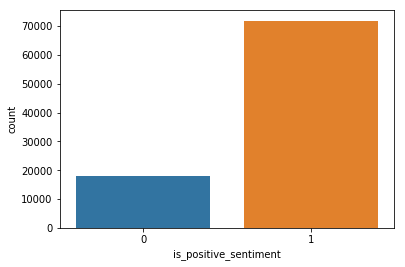

In [76]:
import seaborn as sns

sns.countplot(x='is_positive_sentiment', data=df_scrubbed_raw)


# Write the data file locally

In [38]:
# $S3_BUCKET/feature-store/amazon-reviews/csv/scrubbed-raw-with-header/data.csv

prefix = 'feature-store/amazon-reviews/csv/scrubbed-raw-with-header'

scrubbed_raw_with_header_path = './{}/data.csv'.format(prefix)

import os
os.makedirs(prefix, exist_ok=True)

df_scrubbed_raw.to_csv(scrubbed_raw_with_header_path, index=False, header=True)


# Upload to S3

In [39]:
df_scrubbed_raw_with_header_s3_uri = sess.upload_data(path=scrubbed_raw_with_header_path, key_prefix=prefix)

print(df_scrubbed_raw_with_header_s3_uri)


s3://sagemaker-us-east-1-835319576252/feature-store/amazon-reviews/csv/scrubbed-raw-with-header/data.csv


# Split the data into `train`, `validation`, and `test` datasets

In [40]:
from sklearn.model_selection import train_test_split

# Split all data into 90% train and 10% holdout
df_scrubbed_raw_train, df_scrubbed_raw_holdout = train_test_split(df_scrubbed_raw, test_size=0.1, stratify=df_scrubbed_raw['is_positive_sentiment'])
df_scrubbed_raw_train = df_scrubbed_raw_train.reset_index(drop=True)
df_scrubbed_raw_holdout = df_scrubbed_raw_holdout.reset_index(drop=True)

# Split the holdout into 50% validation and 50% test
df_scrubbed_raw_validation, df_scrubbed_raw_test = train_test_split(df_scrubbed_raw_holdout, test_size=0.5, stratify=df_scrubbed_raw_holdout['is_positive_sentiment'])
df_scrubbed_raw_validation = df_scrubbed_raw_validation.reset_index(drop=True)
df_scrubbed_raw_test = df_scrubbed_raw_test.reset_index(drop=True)

print('df_scrubbed_raw.shape={}'.format(df_scrubbed_raw.shape))
print('df_scrubbed_raw_train.shape={}'.format(df_scrubbed_raw_train.shape))
print('df_scrubbed_raw_validation.shape={}'.format(df_scrubbed_raw_validation.shape))
print('df_scrubbed_raw_test.shape={}'.format(df_scrubbed_raw_test.shape))

df_scrubbed_raw.shape=(89996, 16)
df_scrubbed_raw_train.shape=(80996, 16)
df_scrubbed_raw_validation.shape=(4500, 16)
df_scrubbed_raw_test.shape=(4500, 16)


## Write the data files locally

In [41]:
# $S3_BUCKET/feature-store/amazon-reviews/csv/balanced-raw-with-header/train/data.csv
# $S3_BUCKET/feature-store/amazon-reviews/csv/balanced-raw-with-header/validation/data.csv
# $S3_BUCKET/feature-store/amazon-reviews/csv/balanced-raw-with-header/test/data.csv

prefix_scrubbed_train = 'feature-store/amazon-reviews/csv/scrubbed-raw-with-header/train'
prefix_scrubbed_validation = 'feature-store/amazon-reviews/csv/scrubbed-raw-with-header/validation'
prefix_scrubbed_test = 'feature-store/amazon-reviews/csv/scrubbed-raw-with-header/test'

scrubbed_raw_with_header_train_path = './{}/data.csv'.format(prefix_scrubbed_train)
scrubbed_raw_with_header_validation_path = './{}/data.csv'.format(prefix_scrubbed_validation)
scrubbed_raw_with_header_test_path = './{}/data.csv'.format(prefix_scrubbed_test)

import os
os.makedirs(prefix_scrubbed_train, exist_ok=True)
os.makedirs(prefix_scrubbed_validation, exist_ok=True)
os.makedirs(prefix_scrubbed_test, exist_ok=True)

df_scrubbed_raw_train[['is_positive_sentiment', 'review_body']].to_csv(scrubbed_raw_with_header_train_path, index=False, header=True)
df_scrubbed_raw_validation[['is_positive_sentiment', 'review_body']].to_csv(scrubbed_raw_with_header_validation_path, index=False, header=True)
df_scrubbed_raw_test[['is_positive_sentiment', 'review_body']].to_csv(scrubbed_raw_with_header_test_path, index=False, header=True)


In [42]:
pd.read_csv(scrubbed_raw_with_header_train_path)

,is_positive_sentiment,review_body
0,1,This is a great show. I love it.
1,1,I love the Pink Panther Show Season 1. It is e...
2,1,Yep
3,1,Very cute cartoons it totally caught my 4 year...
4,1,Fun. Action-packed. Best movie of 2015. (Until...
5,0,Don't really get it
6,1,I love the old black and white murder mysterie...
7,1,Walking dead fan. So more walking dead is better.
8,1,Good
9,0,i just wasted 5 dollars and about and hour of ...


# Upload to S3

In [43]:
scrubbed_raw_with_header_train_s3_uri = sess.upload_data(path=scrubbed_raw_with_header_train_path, key_prefix=prefix_scrubbed_train)
scrubbed_raw_with_header_validation_s3_uri = sess.upload_data(path=scrubbed_raw_with_header_validation_path, key_prefix=prefix_scrubbed_validation)
scrubbed_raw_with_header_test_s3_uri = sess.upload_data(path=scrubbed_raw_with_header_test_path, key_prefix=prefix_scrubbed_test)

print(scrubbed_raw_with_header_train_s3_uri)
print(scrubbed_raw_with_header_validation_s3_uri)
print(scrubbed_raw_with_header_test_s3_uri)


s3://sagemaker-us-east-1-835319576252/feature-store/amazon-reviews/csv/scrubbed-raw-with-header/train/data.csv
s3://sagemaker-us-east-1-835319576252/feature-store/amazon-reviews/csv/scrubbed-raw-with-header/validation/data.csv
s3://sagemaker-us-east-1-835319576252/feature-store/amazon-reviews/csv/scrubbed-raw-with-header/test/data.csv


In [44]:
!aws s3 ls $scrubbed_raw_with_header_train_s3_uri
!aws s3 ls $scrubbed_raw_with_header_validation_s3_uri
!aws s3 ls $scrubbed_raw_with_header_test_s3_uri

2020-03-08 22:21:39    8527269 data.csv
2020-03-08 22:21:40     471815 data.csv
2020-03-08 22:21:40     486164 data.csv


# Balance the Dataset between Classes

In [45]:
from sklearn.utils import resample

is_negative_sentiment_df = df_scrubbed_raw.query('is_positive_sentiment == 0')
is_positive_sentiment_df = df_scrubbed_raw.query('is_positive_sentiment == 1')

# TODO:  check which sentiment has the least number of samples

is_positive_downsampled_df = resample(is_positive_sentiment_df,
                                      replace = False,
                                      n_samples = len(is_negative_sentiment_df),
                                      random_state = 27)

df_balanced_raw = pd.concat([is_negative_sentiment_df, is_positive_downsampled_df])
df_balanced_raw = df_balanced_raw.reset_index(drop=True)

In [46]:
df_balanced_raw.head(5)

,is_positive_sentiment,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,0,US,38805573,RH4SXPL4L9QU,B00XWV4QXG,633842417,Entourage: Season 7,Digital_Video_Download,3,0,0,N,Y,it was not as good as the series,"Strange as it is, it was not as good as the se...",2015-08-31
1,0,US,37100714,R37INWIQA5YW8N,B00X8UKOUK,666093513,Catastrophe - Season 1,Digital_Video_Download,2,0,0,N,Y,Two Stars,"Funny shows! We laughed out loud, alot!",2015-08-31
2,0,US,41234409,R18GSVAAS3N8GX,B00OOKXTFU,801680808,The Worricker Trilogy Season 1,Digital_Video_Download,3,0,0,N,Y,A tad Stuffy,Well made. Great actors! Christopher Walken ma...,2015-08-31
3,0,US,12411752,R2SWNCCEH2HPM5,B01347T9O8,331499516,Casanova,Digital_Video_Download,1,0,0,N,Y,One Star,"Not my kind of movie, one star was too much",2015-08-31
4,0,US,14717869,R127KV8E8ZC5L4,B00EC7VQX2,627579257,Boardwalk Empire Season 3,Digital_Video_Download,1,0,1,N,Y,I would have given it a 4 but since I ...,I would have given it a 4 but since I can't ge...,2015-08-31


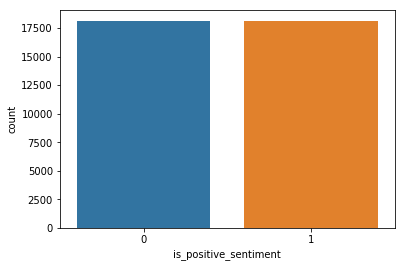

In [47]:
import seaborn as sns

sns.countplot(x='is_positive_sentiment', data=df_balanced_raw)


## Split the data into `train`, `validation`, and `test` datasets

In [77]:
from sklearn.model_selection import train_test_split

# Split all data into 90% train and 10% holdout
df_balanced_raw_train, df_balanced_raw_holdout = train_test_split(df_balanced_raw, test_size=0.1, stratify=df_balanced_raw['is_positive_sentiment'])
df_balanced_raw_train = df_balanced_raw_train.reset_index(drop=True)
df_balanced_raw_holdout = df_balanced_raw_holdout.reset_index(drop=True)

# Split the holdout into 50% validation and 50% test
df_balanced_raw_validation, df_balanced_raw_test = train_test_split(df_balanced_raw_holdout, test_size=0.5, stratify=df_balanced_raw_holdout['is_positive_sentiment'])
df_balanced_raw_validation = df_balanced_raw_validation.reset_index(drop=True)
df_balanced_raw_test = df_balanced_raw_test.reset_index(drop=True)

print('df_balanced_raw.shape={}'.format(df_balanced_raw.shape))
print('df_balanced_raw_train.shape={}'.format(df_balanced_raw_train.shape))
print('df_balanced_raw_validation.shape={}'.format(df_balanced_raw_validation.shape))
print('df_balanced_raw_test.shape={}'.format(df_balanced_raw_test.shape))

df_balanced_raw.shape=(36272, 16)
df_balanced_raw_train.shape=(32644, 16)
df_balanced_raw_validation.shape=(1814, 16)
df_balanced_raw_test.shape=(1814, 16)


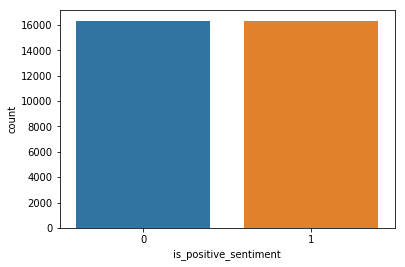

In [78]:
import seaborn as sns

sns.countplot(x='is_positive_sentiment', data=df_balanced_raw_train)


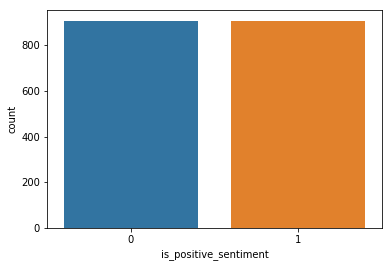

In [79]:
import seaborn as sns

sns.countplot(x='is_positive_sentiment', data=df_balanced_raw_validation)


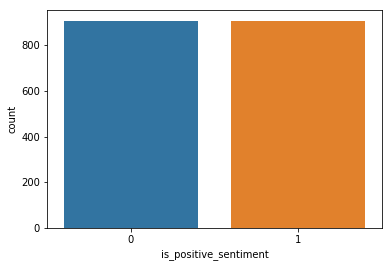

In [80]:
import seaborn as sns

sns.countplot(x='is_positive_sentiment', data=df_balanced_raw_test)


## Write the data file locally

In [81]:
# $S3_BUCKET/feature-store/amazon-reviews/csv/balanced-raw-with-header/train/data.csv
# $S3_BUCKET/feature-store/amazon-reviews/csv/balanced-raw-with-header/validation/data.csv
# $S3_BUCKET/feature-store/amazon-reviews/csv/balanced-raw-with-header/test/data.csv

prefix_train = 'feature-store/amazon-reviews/csv/balanced-raw-with-header/train'
prefix_validation = 'feature-store/amazon-reviews/csv/balanced-raw-with-header/validation'
prefix_test = 'feature-store/amazon-reviews/csv/balanced-raw-with-header/test'

balanced_raw_with_header_train_path = './{}/data.csv'.format(prefix_train)
balanced_raw_with_header_validation_path = './{}/data.csv'.format(prefix_validation)
balanced_raw_with_header_test_path = './{}/data.csv'.format(prefix_test)

import os
os.makedirs(prefix_train, exist_ok=True)
os.makedirs(prefix_validation, exist_ok=True)
os.makedirs(prefix_test, exist_ok=True)

df_balanced_raw_train[['is_positive_sentiment', 'review_body']].to_csv(balanced_raw_with_header_train_path, index=False, header=True)
df_balanced_raw_validation[['is_positive_sentiment', 'review_body']].to_csv(balanced_raw_with_header_validation_path, index=False, header=True)
df_balanced_raw_test[['is_positive_sentiment', 'review_body']].to_csv(balanced_raw_with_header_test_path, index=False, header=True)


In [82]:
pd.read_csv(balanced_raw_with_header_train_path)

,is_positive_sentiment,review_body
0,0,The rebranding of main characters was unusual ...
1,0,Goodness what a let down. To give Sandra such ...
2,1,Good season so far first time watching it
3,0,"Love Phillip Seymour Hoffman, but didn't like ..."
4,1,Glad I found this series. Can'wait for season 9.
5,0,average movie.
6,1,"Funny, would like to see more."
7,1,"Slow, but worth watching."
8,0,A little too much soft porn
9,0,"No narration, pretty boring"


# Upload to S3

In [83]:
balanced_raw_with_header_train_s3_uri = sess.upload_data(path=balanced_raw_with_header_train_path, key_prefix=prefix_train)
balanced_raw_with_header_validation_s3_uri = sess.upload_data(path=balanced_raw_with_header_validation_path, key_prefix=prefix_validation)
balanced_raw_with_header_test_s3_uri = sess.upload_data(path=balanced_raw_with_header_test_path, key_prefix=prefix_test)

print(balanced_raw_with_header_train_s3_uri)
print(balanced_raw_with_header_validation_s3_uri)
print(balanced_raw_with_header_test_s3_uri)


s3://sagemaker-us-east-1-835319576252/feature-store/amazon-reviews/csv/balanced-raw-with-header/train/data.csv
s3://sagemaker-us-east-1-835319576252/feature-store/amazon-reviews/csv/balanced-raw-with-header/validation/data.csv
s3://sagemaker-us-east-1-835319576252/feature-store/amazon-reviews/csv/balanced-raw-with-header/test/data.csv


In [84]:
!aws s3 ls $balanced_raw_with_header_train_s3_uri
!aws s3 ls $balanced_raw_with_header_validation_s3_uri
!aws s3 ls $balanced_raw_with_header_test_s3_uri

2020-03-08 22:24:07    3869396 data.csv
2020-03-08 22:24:07     206493 data.csv
2020-03-08 22:24:07     219235 data.csv


# Transform the raw text into TF/IDF features

In [85]:
from sklearn.decomposition import TruncatedSVD
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

def feature_transform_fn(df_text, column_name, num_components):
    text_processors = Pipeline(
        steps=[
            (
                'tfidfvectorizer',
                TfidfVectorizer(
                    max_df=0.25,                                       
                    min_df=.0025,
                    analyzer='word',
                    max_features=10000
                )
            )
        ]
    )

    column_transformer = ColumnTransformer(
        transformers=[('text_processing', text_processors, df_text.columns.get_loc(column_name))]
    )

    pipeline = Pipeline(
        steps=[
            ('column_transformer',
             column_transformer), ('svd', TruncatedSVD(n_components=num_components)),
            ('standardscaler', StandardScaler())
        ]
    )

    return pipeline

# Scrubbed Raw with TF/IDF (aka. Unbalanced)

# Train - Transform just the features (X)
_This will run for a minute or two.  Please be patient._

In [86]:
df_X_scrubbed_raw = df_scrubbed_raw[['review_body']]
df_y_scrubbed_raw = df_scrubbed_raw['is_positive_sentiment']

df_X_scrubbed_raw.shape

(89996, 1)

In [87]:
pipeline_scrubbed = feature_transform_fn(df_X_scrubbed_raw, 'review_body', 300)
np_tfidf_scrubbed = pipeline_scrubbed.fit_transform(df_X_scrubbed_raw)
df_tfidf_scrubbed = pd.DataFrame(np_tfidf_scrubbed)
df_tfidf_scrubbed.shape

(89996, 300)

## Show the learned TF/IDF features for each sentence

In [88]:
vectorizer_tfidf = pipeline_scrubbed \
    .named_steps['column_transformer'] \
    .transformers[0][1].named_steps['tfidfvectorizer']

vectorizer_tfidf_fitted = vectorizer_tfidf.fit_transform(df_scrubbed_raw['review_body'])

In [89]:
df_vectorizer_tfidf = pd.DataFrame(vectorizer_tfidf_fitted.toarray())
df_vectorizer_tfidf.columns = vectorizer_tfidf.get_feature_names()
df_vectorizer_tfidf.shape

(89996, 666)

In [90]:
df_vectorizer_tfidf.head(5)

,10,34,able,about,absolutely,acted,acting,action,actor,actors,...,writing,written,wrong,year,years,yes,yet,you,young,your
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.194123,0.0,0.101453,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0


In [91]:
df_scrubbed_raw_with_tfidf = pd.merge(df_scrubbed_raw['review_body'], 
                                      df_vectorizer_tfidf,
                                      left_index=True,
                                      right_index=True)
df_scrubbed_raw_with_tfidf.head(5)

,review_body,10,34,able,about,absolutely,acted,acting,action,actor,...,writing,written,wrong,year,years,yes,yet,you,young,your
0,I loved it and I wish there was a season 3... ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
1,As always it seems that the best shows come fr...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
2,"This movie isn't perfect, but it gets a lot of...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.194123,0.0,0.101453,0.0,0.0
3,excellant this is what tv should be,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
4,Brilliant film from beginning to end. All of t...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0


In [66]:
#vectorizer = pipeline.named_steps['column_transformer'].transformers[0][1].named_steps['tfidfvectorizer']
#vectorizer.fit_transform(df_X_balanced_raw)
#vectorizer.get_feature_names()

In [67]:
#vectorizer = TfidfVectorizer(stop_words='english')
#df_tfidf = vectorizer.fit_transform(text)

#feature_names = vectorizer.get_feature_names()
#print(feature_names)

#df_tfidf = pd.DataFrame(vectorizer.idf_, 
#                        index=vectorizer.get_feature_names(),
#                        columns=['idf'])

#df_tfidf = pd.DataFrame(X.todense(),columns=vectorizer.get_feature_names())
#df_tfidf.head(5)

### Use t-SNE to Visualize the Data

_Note:  This takes a while.  Please be patient._

In [ ]:
# from sklearn.manifold import TSNE

# tsne_model_train = TSNE(perplexity=10, n_components=2, init='pca', n_iter=250, random_state=10)
# np_tsne_train = tsne_model_train.fit_transform(df_vectorizer_tfidf)


In [ ]:
# import matplotlib.pyplot as plt

# # column 0-299
# labels = df_tdf_vectorizer_tfidf.columns.values
# x = []
# y = []
# for value in np_tsne:
#     x.append(value[0])
#     y.append(value[1])

# plt.figure(figsize=(16, 16)) 
# # TODO:  Check the -1
# for i in range(len(x) - 1):
#     plt.scatter(x[i],y[i])
#     plt.annotate(labels[i],
#                  xy=(x[i], y[i]),
#                  xytext=(5, 2),
#                  textcoords='offset points',
#                  ha='right',
#                  va='bottom')
# plt.show()

## Combine the features with the labels 

In [92]:
df_tfidf_scrubbed.head(5)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.289176,-0.404525,-0.102251,-0.818109,-0.052808,0.306817,-0.382521,1.434246,-2.847508,3.362726,...,-0.405762,0.228952,-0.239639,0.362774,0.269907,-0.529379,-0.146486,-0.202934,0.243313,0.157159
1,-0.330496,-0.443258,-0.015376,-0.947481,0.217240,-0.158132,-0.534904,-0.376839,0.103452,-0.105934,...,0.074071,-0.226365,1.057468,-1.191292,-1.087544,0.495915,-0.208267,0.104685,1.134549,-1.512086
2,0.637207,-1.014613,-0.095304,-1.289979,-0.357594,0.008992,-0.435982,-0.074077,0.018258,-0.630508,...,1.086309,-1.691724,-1.503101,1.741523,1.911208,-1.434943,-0.568574,-0.254918,2.087280,-0.038988
3,-0.316980,-0.433755,0.239025,-0.616055,0.044040,0.174884,-0.509957,0.054905,-0.013417,-0.404189,...,0.082313,-0.000342,0.570867,0.831744,0.792806,-0.645141,0.008811,-0.010515,0.591723,-0.010122
4,-0.308821,-0.494098,0.061246,-0.823974,-0.041569,-0.178691,-0.369525,-0.219495,0.013453,-0.269509,...,0.517200,-0.623388,1.392123,-0.304872,1.878282,0.523955,1.570939,-0.971044,0.934565,1.209765


In [93]:
df_y_scrubbed_raw.head(5)

0    1
1    1
2    1
3    1
4    1
Name: is_positive_sentiment, dtype: int64

In [94]:
df_tfidf_scrubbed.insert(0, 'is_positive_sentiment', df_y_scrubbed_raw)
df_tfidf_scrubbed.shape

(89996, 301)

In [95]:
df_tfidf_scrubbed.head(5)

,is_positive_sentiment,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
0,1,-0.289176,-0.404525,-0.102251,-0.818109,-0.052808,0.306817,-0.382521,1.434246,-2.847508,...,-0.405762,0.228952,-0.239639,0.362774,0.269907,-0.529379,-0.146486,-0.202934,0.243313,0.157159
1,1,-0.330496,-0.443258,-0.015376,-0.947481,0.217240,-0.158132,-0.534904,-0.376839,0.103452,...,0.074071,-0.226365,1.057468,-1.191292,-1.087544,0.495915,-0.208267,0.104685,1.134549,-1.512086
2,1,0.637207,-1.014613,-0.095304,-1.289979,-0.357594,0.008992,-0.435982,-0.074077,0.018258,...,1.086309,-1.691724,-1.503101,1.741523,1.911208,-1.434943,-0.568574,-0.254918,2.087280,-0.038988
3,1,-0.316980,-0.433755,0.239025,-0.616055,0.044040,0.174884,-0.509957,0.054905,-0.013417,...,0.082313,-0.000342,0.570867,0.831744,0.792806,-0.645141,0.008811,-0.010515,0.591723,-0.010122
4,1,-0.308821,-0.494098,0.061246,-0.823974,-0.041569,-0.178691,-0.369525,-0.219495,0.013453,...,0.517200,-0.623388,1.392123,-0.304872,1.878282,0.523955,1.570939,-0.971044,0.934565,1.209765


## Write the data locally

In [96]:
# $S3_BUCKET/feature-store/csv/amazon-reviews/scrubbed-tfidf-without-header

prefix_scrubbed = 'feature-store/amazon-reviews/csv/scrubbed-tfidf-without-header'

scrubbed_tfidf_without_header_path = './{}/data.csv'.format(prefix_scrubbed)

import os
os.makedirs(prefix_scrubbed, exist_ok=True)

df_tfidf_scrubbed.to_csv(scrubbed_tfidf_without_header_path, index=False, header=None)


# Upload to S3

In [97]:
df_scrubbed_tfidf_without_header_s3_uri = sess.upload_data(path=scrubbed_tfidf_without_header_path, key_prefix=prefix_scrubbed)

print(df_scrubbed_tfidf_without_header_s3_uri)


s3://sagemaker-us-east-1-835319576252/feature-store/amazon-reviews/csv/scrubbed-tfidf-without-header/data.csv


In [98]:
!aws s3 ls $df_scrubbed_tfidf_without_header_s3_uri

2020-03-08 22:24:59  541127157 data.csv


# Convert Scrubbed Raw Train, Validation, Test into TF/IDF

In [99]:
# Features (X), # Labels (y)
df_X_scrubbed_raw_train = df_scrubbed_raw_train[['review_body']]
df_y_scrubbed_raw_train = df_scrubbed_raw_train['is_positive_sentiment']

df_X_scrubbed_raw_validation = df_scrubbed_raw_validation[['review_body']]
df_y_scrubbed_raw_validation = df_scrubbed_raw_validation['is_positive_sentiment']

df_X_scrubbed_raw_test = df_scrubbed_raw_test[['review_body']]
df_y_scrubbed_raw_test = df_scrubbed_raw_test['is_positive_sentiment']

print('df_scrubbed_X_raw_train.shape:  {}'.format(df_X_scrubbed_raw_train.shape))
print('df_scrubbed_y_raw_train.shape:  {}'.format(df_y_scrubbed_raw_train.shape))
print('df_scrubbed_X_raw_validation.shape:  {}'.format(df_X_scrubbed_raw_validation.shape))
print('df_scrubbed_y_raw_validation.shape:  {}'.format(df_y_scrubbed_raw_validation.shape))
print('df_scrubbed_X_raw_test.shape:  {}'.format(df_X_scrubbed_raw_test.shape))
print('df_scrubbed_y_raw_test.shape:  {}'.format(df_y_scrubbed_raw_test.shape))

df_scrubbed_X_raw_train.shape:  (80996, 1)
df_scrubbed_y_raw_train.shape:  (80996,)
df_scrubbed_X_raw_validation.shape:  (4500, 1)
df_scrubbed_y_raw_validation.shape:  (4500,)
df_scrubbed_X_raw_test.shape:  (4500, 1)
df_scrubbed_y_raw_test.shape:  (4500,)


In [100]:
df_X_scrubbed_raw_train.head(5)

,review_body
0,This is a great show. I love it.
1,I love the Pink Panther Show Season 1. It is e...
2,Yep
3,Very cute cartoons it totally caught my 4 year...
4,Fun. Action-packed. Best movie of 2015. (Until...


In [101]:
df_y_scrubbed_raw_train.head(5)

0    1
1    1
2    1
3    1
4    1
Name: is_positive_sentiment, dtype: int64

# Train - Transform just the features (X)
_This will run for a minute or two.  Please be patient._

In [103]:
pipeline_scrubbed_train = feature_transform_fn(df_X_scrubbed_raw_train, 'review_body', 300)
np_tfidf_scrubbed_train = pipeline_scrubbed_train.fit_transform(df_X_scrubbed_raw_train)
df_tfidf_scrubbed_train = pd.DataFrame(np_tfidf_scrubbed_train)
df_tfidf_scrubbed_train.shape

(80996, 300)

In [104]:
df_tfidf_scrubbed_train.head(5)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,3.537882,0.916210,3.237876,1.107776,0.879193,0.078290,-0.630543,-0.311293,-0.134781,-0.721845,...,0.030153,-0.048829,0.010977,-0.103370,0.090288,-0.024412,0.077993,0.032047,0.098137,-0.115269
1,0.262732,-0.519164,0.897235,-0.209378,0.444279,-0.010234,-0.003622,-0.053890,-0.158457,-0.426243,...,-0.566746,-1.783409,1.040903,1.099546,0.054402,-0.929361,0.114459,0.626201,-0.040041,-0.385715
2,-1.383225,0.298481,0.031919,0.133541,-0.016708,-0.032477,-0.122115,0.013059,-0.017616,-0.127427,...,-0.002766,-0.008498,-0.009377,-0.004295,-0.007693,-0.003308,-0.005746,0.000984,-0.011059,-0.003180
3,-0.871251,-0.062991,-0.100573,0.044820,0.107819,-0.054372,1.129730,-0.844194,0.268147,-0.325794,...,-0.677813,-2.087200,0.249251,2.281141,-2.352613,-0.271387,0.174379,-1.538159,1.669562,2.425529
4,-0.268832,-0.137489,-0.391573,-0.254295,-0.740380,0.455342,-0.559404,-0.031532,-0.371709,-0.573113,...,-2.785542,-2.604073,2.003617,-1.411326,0.362163,0.128559,0.737787,0.429634,0.818466,-0.267354


In [105]:
df_y_scrubbed_raw_train.head(5)

0    1
1    1
2    1
3    1
4    1
Name: is_positive_sentiment, dtype: int64

# Add back the label (y) into the first column
The label needs to be in the 1st column for some of our models.

In [106]:
df_tfidf_scrubbed_train.insert(0, 'is_positive_sentiment', df_y_scrubbed_raw_train)
df_tfidf_scrubbed_train.shape

(80996, 301)

In [107]:
df_tfidf_scrubbed_train.head(5)

,is_positive_sentiment,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
0,1,3.537882,0.916210,3.237876,1.107776,0.879193,0.078290,-0.630543,-0.311293,-0.134781,...,0.030153,-0.048829,0.010977,-0.103370,0.090288,-0.024412,0.077993,0.032047,0.098137,-0.115269
1,1,0.262732,-0.519164,0.897235,-0.209378,0.444279,-0.010234,-0.003622,-0.053890,-0.158457,...,-0.566746,-1.783409,1.040903,1.099546,0.054402,-0.929361,0.114459,0.626201,-0.040041,-0.385715
2,1,-1.383225,0.298481,0.031919,0.133541,-0.016708,-0.032477,-0.122115,0.013059,-0.017616,...,-0.002766,-0.008498,-0.009377,-0.004295,-0.007693,-0.003308,-0.005746,0.000984,-0.011059,-0.003180
3,1,-0.871251,-0.062991,-0.100573,0.044820,0.107819,-0.054372,1.129730,-0.844194,0.268147,...,-0.677813,-2.087200,0.249251,2.281141,-2.352613,-0.271387,0.174379,-1.538159,1.669562,2.425529
4,1,-0.268832,-0.137489,-0.391573,-0.254295,-0.740380,0.455342,-0.559404,-0.031532,-0.371709,...,-2.785542,-2.604073,2.003617,-1.411326,0.362163,0.128559,0.737787,0.429634,0.818466,-0.267354


# Validation - Transform just the features (X)
_This will run for a minute or two.  Please be patient._

In [108]:
pipeline_scrubbed_validation = feature_transform_fn(df_X_scrubbed_raw_validation, 'review_body', 300)
np_tfidf_scrubbed_validation = pipeline_scrubbed_validation.fit_transform(df_X_scrubbed_raw_validation)
df_tfidf_scrubbed_validation = pd.DataFrame(np_tfidf_scrubbed_validation)
df_tfidf_scrubbed_validation.shape

(4500, 300)

In [109]:
df_tfidf_scrubbed_validation.head(5)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.545451,-0.852758,0.662890,-0.904455,0.214212,-0.459213,-0.790193,0.178050,-0.061499,0.166943,...,-1.286178,-1.066550,1.389645,-0.650976,0.088077,0.018689,0.395463,0.898761,1.175397,1.027323
1,-1.191194,0.181850,0.112136,0.180647,0.083424,-0.645355,2.522141,-1.349589,-2.820364,7.925447,...,0.002052,0.055809,0.058605,-0.057521,0.092897,-0.076382,-0.022592,-0.048754,-0.142449,-0.157817
2,-0.288488,-0.392759,-0.476031,-0.259147,-0.299371,1.989854,-0.400687,-0.139046,-0.350822,0.094801,...,0.678281,-0.039153,-0.405992,-0.388974,-0.075990,0.436433,-0.110607,-0.150192,-0.246563,0.639975
3,-0.868778,-0.093808,0.027481,-0.384807,-0.122125,-0.283568,-0.245749,-0.032656,0.012794,-0.097918,...,-0.927375,-0.098742,1.717702,-1.285024,1.156439,0.494186,0.293239,-0.020201,-0.231037,1.239537
4,0.623368,-0.580340,4.075075,3.083819,1.915295,0.845428,-2.391733,0.427735,0.267536,0.686746,...,0.032480,0.055443,0.007049,0.085328,-0.004079,0.028975,-0.043715,0.050396,-0.124924,-0.085911


# Add back the label (y) into the first column
The label needs to be in the 1st column for some of our models.

In [110]:
df_tfidf_scrubbed_validation.insert(0, 'is_positive_sentiment', df_y_scrubbed_raw_validation)
df_tfidf_scrubbed_validation.shape

(4500, 301)

In [111]:
df_tfidf_scrubbed_validation.head(5)

,is_positive_sentiment,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
0,1,0.545451,-0.852758,0.662890,-0.904455,0.214212,-0.459213,-0.790193,0.178050,-0.061499,...,-1.286178,-1.066550,1.389645,-0.650976,0.088077,0.018689,0.395463,0.898761,1.175397,1.027323
1,1,-1.191194,0.181850,0.112136,0.180647,0.083424,-0.645355,2.522141,-1.349589,-2.820364,...,0.002052,0.055809,0.058605,-0.057521,0.092897,-0.076382,-0.022592,-0.048754,-0.142449,-0.157817
2,0,-0.288488,-0.392759,-0.476031,-0.259147,-0.299371,1.989854,-0.400687,-0.139046,-0.350822,...,0.678281,-0.039153,-0.405992,-0.388974,-0.075990,0.436433,-0.110607,-0.150192,-0.246563,0.639975
3,1,-0.868778,-0.093808,0.027481,-0.384807,-0.122125,-0.283568,-0.245749,-0.032656,0.012794,...,-0.927375,-0.098742,1.717702,-1.285024,1.156439,0.494186,0.293239,-0.020201,-0.231037,1.239537
4,1,0.623368,-0.580340,4.075075,3.083819,1.915295,0.845428,-2.391733,0.427735,0.267536,...,0.032480,0.055443,0.007049,0.085328,-0.004079,0.028975,-0.043715,0.050396,-0.124924,-0.085911


# Test - Transform just the features (X)
_This will run for a minute or two.  Please be patient._

In [112]:
pipeline_scrubbed_test = feature_transform_fn(df_X_scrubbed_raw_test, 'review_body', 300)
np_tfidf_scrubbed_test = pipeline_scrubbed_test.fit_transform(df_X_scrubbed_raw_test)
df_tfidf_scrubbed_test = pd.DataFrame(np_tfidf_scrubbed_test)
df_tfidf_scrubbed_test.shape

(4500, 300)

In [113]:
df_tfidf_scrubbed_test.head(5)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.268624,-0.513009,-0.279960,-0.806453,0.168453,-0.293850,0.058398,-0.635261,0.365003,-0.400247,...,0.333688,-1.505046,0.972236,-0.782418,-1.914360,-2.966387,1.239815,-1.592177,-1.931329,-1.792618
1,-1.227343,0.183452,0.035037,-0.024664,-0.018021,-0.111055,-0.079630,-0.125408,-0.041528,-0.166534,...,3.333471,2.952447,0.074024,1.830094,1.795279,0.700223,-2.268061,-2.590392,-4.289718,2.282831
2,0.471295,-0.032510,-0.050032,-0.965062,-0.014915,-0.346336,-0.016975,-0.734502,0.104558,-0.333024,...,0.714666,-2.985413,0.394550,-0.586549,-1.894703,0.851849,2.870518,-1.439692,1.054285,-0.867976
3,-1.009438,0.180789,0.014792,0.168545,-0.660473,7.064912,1.842862,-1.490929,1.339470,-0.054445,...,-0.039554,0.046111,0.029002,0.082482,-0.008491,-0.020459,-0.002770,-0.007220,-0.044859,-0.020773
4,1.035328,0.535814,2.030482,0.760904,4.419086,1.672114,-2.248100,2.150681,-3.009359,-0.903364,...,0.007408,0.014866,-0.142140,-0.233556,0.080189,-0.169993,-0.072968,0.078338,0.008671,0.110419


# Add back the label (y) into the first column
The label needs to be in the 1st column for some of our models.

In [114]:
df_tfidf_scrubbed_test.insert(0, 'is_positive_sentiment', df_y_scrubbed_raw_test)
df_tfidf_scrubbed_test.shape

(4500, 301)

In [115]:
df_tfidf_scrubbed_test.head(5)

,is_positive_sentiment,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
0,1,-0.268624,-0.513009,-0.279960,-0.806453,0.168453,-0.293850,0.058398,-0.635261,0.365003,...,0.333688,-1.505046,0.972236,-0.782418,-1.914360,-2.966387,1.239815,-1.592177,-1.931329,-1.792618
1,1,-1.227343,0.183452,0.035037,-0.024664,-0.018021,-0.111055,-0.079630,-0.125408,-0.041528,...,3.333471,2.952447,0.074024,1.830094,1.795279,0.700223,-2.268061,-2.590392,-4.289718,2.282831
2,1,0.471295,-0.032510,-0.050032,-0.965062,-0.014915,-0.346336,-0.016975,-0.734502,0.104558,...,0.714666,-2.985413,0.394550,-0.586549,-1.894703,0.851849,2.870518,-1.439692,1.054285,-0.867976
3,1,-1.009438,0.180789,0.014792,0.168545,-0.660473,7.064912,1.842862,-1.490929,1.339470,...,-0.039554,0.046111,0.029002,0.082482,-0.008491,-0.020459,-0.002770,-0.007220,-0.044859,-0.020773
4,1,1.035328,0.535814,2.030482,0.760904,4.419086,1.672114,-2.248100,2.150681,-3.009359,...,0.007408,0.014866,-0.142140,-0.233556,0.080189,-0.169993,-0.072968,0.078338,0.008671,0.110419


# Write the datasets locally
_Note: `header=None`_

In [116]:
# $S3_BUCKET/feature-store/csv/amazon-reviews/scrubbed-tfidf-without-header/train/data.csv
# $S3_BUCKET/feature-store/csv/amazon-reviews/scrubbed-tfidf-without-header/validation/data.csv
# $S3_BUCKET/feature-store/csv/amazon-reviews/scrubbed-tfidf-without-header/test/data.csv

prefix_scrubbed_train = 'feature-store/amazon-reviews/csv/scrubbed-tfidf-without-header/train'
prefix_scrubbed_validation = 'feature-store/amazon-reviews/csv/scrubbed-tfidf-without-header/validation'
prefix_scrubbed_test = 'feature-store/amazon-reviews/csv/scrubbed-tfidf-without-header/test'

scrubbed_tfidf_without_header_train_path = './{}/data.csv'.format(prefix_scrubbed_train)
scrubbed_tfidf_without_header_validation_path = './{}/data.csv'.format(prefix_scrubbed_validation)
scrubbed_tfidf_without_header_test_path = './{}/data.csv'.format(prefix_scrubbed_test)

import os
os.makedirs(prefix_scrubbed_train, exist_ok=True)
os.makedirs(prefix_scrubbed_validation, exist_ok=True)
os.makedirs(prefix_scrubbed_test, exist_ok=True)

df_tfidf_scrubbed_train.to_csv(scrubbed_tfidf_without_header_train_path, index=False, header=None)
df_tfidf_scrubbed_validation.to_csv(scrubbed_tfidf_without_header_validation_path, index=False, header=None)
df_tfidf_scrubbed_test.to_csv(scrubbed_tfidf_without_header_test_path, index=False, header=None)


# Upload to S3

In [117]:
df_scrubbed_tfidf_without_header_train_s3_uri = sess.upload_data(path=scrubbed_tfidf_without_header_train_path, key_prefix=prefix_scrubbed_train)
df_scrubbed_tfidf_without_header_validation_s3_uri = sess.upload_data(path=scrubbed_tfidf_without_header_validation_path, key_prefix=prefix_scrubbed_validation)
df_scrubbed_tfidf_without_header_test_s3_uri = sess.upload_data(path=scrubbed_tfidf_without_header_test_path, key_prefix=prefix_scrubbed_test)

print(df_scrubbed_tfidf_without_header_train_s3_uri)
print(df_scrubbed_tfidf_without_header_validation_s3_uri)
print(df_scrubbed_tfidf_without_header_test_s3_uri)


s3://sagemaker-us-east-1-835319576252/feature-store/amazon-reviews/csv/scrubbed-tfidf-without-header/train/data.csv
s3://sagemaker-us-east-1-835319576252/feature-store/amazon-reviews/csv/scrubbed-tfidf-without-header/validation/data.csv
s3://sagemaker-us-east-1-835319576252/feature-store/amazon-reviews/csv/scrubbed-tfidf-without-header/test/data.csv


In [118]:
!aws s3 ls $df_scrubbed_tfidf_without_header_train_s3_uri
!aws s3 ls $df_scrubbed_tfidf_without_header_validation_s3_uri
!aws s3 ls $df_scrubbed_tfidf_without_header_test_s3_uri

2020-03-08 22:35:03  486980303 data.csv
2020-03-08 22:35:07   26865996 data.csv
2020-03-08 22:35:07   26872283 data.csv


# Balanced Raw

In [119]:
# Features (X), # Labels (y)
df_X_balanced_raw_train = df_balanced_raw_train[['review_body']]
df_y_balanced_raw_train = df_balanced_raw_train['is_positive_sentiment']

df_X_balanced_raw_validation = df_balanced_raw_validation[['review_body']]
df_y_balanced_raw_validation = df_balanced_raw_validation['is_positive_sentiment']

df_X_balanced_raw_test = df_balanced_raw_test[['review_body']]
df_y_balanced_raw_test = df_balanced_raw_test['is_positive_sentiment']

print('df_balanced_X_raw_train.shape:  {}'.format(df_X_balanced_raw_train.shape))
print('df_balanced_y_raw_train.shape:  {}'.format(df_y_balanced_raw_train.shape))
print('df_balanced_X_raw_validation.shape:  {}'.format(df_X_balanced_raw_validation.shape))
print('df_balanced_y_raw_validation.shape:  {}'.format(df_y_balanced_raw_validation.shape))
print('df_balanced_X_raw_test.shape:  {}'.format(df_X_balanced_raw_test.shape))
print('df_balanced_y_raw_test.shape:  {}'.format(df_y_balanced_raw_test.shape))

df_balanced_X_raw_train.shape:  (32644, 1)
df_balanced_y_raw_train.shape:  (32644,)
df_balanced_X_raw_validation.shape:  (1814, 1)
df_balanced_y_raw_validation.shape:  (1814,)
df_balanced_X_raw_test.shape:  (1814, 1)
df_balanced_y_raw_test.shape:  (1814,)


In [120]:
df_X_balanced_raw_train.head(5)

,review_body
0,The rebranding of main characters was unusual ...
1,Goodness what a let down. To give Sandra such ...
2,Good season so far first time watching it
3,"Love Phillip Seymour Hoffman, but didn't like ..."
4,Glad I found this series. Can'wait for season 9.


In [121]:
df_y_balanced_raw_train.head(5)

0    0
1    0
2    1
3    0
4    1
Name: is_positive_sentiment, dtype: int64

# Train - Transform just the features (X)
_This will run for a minute or two.  Please be patient._

In [122]:
pipeline_train = feature_transform_fn(df_X_balanced_raw_train, 'review_body', 300)
np_tfidf_train = pipeline_train.fit_transform(df_X_balanced_raw_train)
df_tfidf_train = pd.DataFrame(np_tfidf_train)
df_tfidf_train.shape

(32644, 300)

In [123]:
df_tfidf_train.head(5)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.172444,-0.613249,-0.559968,-0.423594,-0.068933,0.017411,0.094863,-0.439788,-0.327813,-0.202037,...,1.692725,-0.077304,-2.301148,-0.682009,-1.411466,-3.080295,2.161567,2.569480,0.222770,-4.044807
1,0.815311,-0.764613,-0.504699,-0.668326,0.195219,-0.130254,0.286940,-0.371527,0.146384,-0.352606,...,0.667031,-0.923872,-1.344952,1.531010,-1.575466,0.728590,-1.546132,-0.603935,-0.920277,1.508875
2,-0.023712,-0.423500,1.096536,0.462808,-0.988305,-0.026301,-0.289250,-1.016070,-0.082126,0.197220,...,0.731422,0.614763,0.547028,0.029983,1.195960,-0.509035,-1.060340,0.573780,0.120021,-0.356543
3,-0.148748,-0.217592,-0.862525,1.796075,1.058548,-0.070690,-1.518318,-0.463269,0.563722,0.256745,...,-0.326215,0.157167,0.011444,0.071668,0.263042,0.209682,0.040383,-0.020595,0.080807,-0.136270
4,-0.285217,-0.141128,-0.611845,0.108635,-0.272378,-0.304879,-0.000262,-0.481801,-1.098534,0.615762,...,-0.521342,-1.049770,-0.331937,-0.955910,-1.281276,-0.469670,0.446578,0.201311,-1.559384,-1.438145


In [124]:
df_y_balanced_raw_train.head(5)

0    0
1    0
2    1
3    0
4    1
Name: is_positive_sentiment, dtype: int64

# Add back the label (y) into the first column
The label needs to be in the 1st column for some of our models.

In [125]:
df_tfidf_train.insert(0, 'is_positive_sentiment', df_y_balanced_raw_train)
df_tfidf_train.shape

(32644, 301)

In [126]:
df_tfidf_train.head(5)

,is_positive_sentiment,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
0,0,0.172444,-0.613249,-0.559968,-0.423594,-0.068933,0.017411,0.094863,-0.439788,-0.327813,...,1.692725,-0.077304,-2.301148,-0.682009,-1.411466,-3.080295,2.161567,2.569480,0.222770,-4.044807
1,0,0.815311,-0.764613,-0.504699,-0.668326,0.195219,-0.130254,0.286940,-0.371527,0.146384,...,0.667031,-0.923872,-1.344952,1.531010,-1.575466,0.728590,-1.546132,-0.603935,-0.920277,1.508875
2,1,-0.023712,-0.423500,1.096536,0.462808,-0.988305,-0.026301,-0.289250,-1.016070,-0.082126,...,0.731422,0.614763,0.547028,0.029983,1.195960,-0.509035,-1.060340,0.573780,0.120021,-0.356543
3,0,-0.148748,-0.217592,-0.862525,1.796075,1.058548,-0.070690,-1.518318,-0.463269,0.563722,...,-0.326215,0.157167,0.011444,0.071668,0.263042,0.209682,0.040383,-0.020595,0.080807,-0.136270
4,1,-0.285217,-0.141128,-0.611845,0.108635,-0.272378,-0.304879,-0.000262,-0.481801,-1.098534,...,-0.521342,-1.049770,-0.331937,-0.955910,-1.281276,-0.469670,0.446578,0.201311,-1.559384,-1.438145


# Validation - Transform just the features (X)
_This will run for a minute or two.  Please be patient._

In [127]:
pipeline_validation = feature_transform_fn(df_X_balanced_raw_validation, 'review_body', 300)
np_tfidf_validation = pipeline_validation.fit_transform(df_X_balanced_raw_validation)
df_tfidf_validation = pd.DataFrame(np_tfidf_validation)
df_tfidf_validation.shape

(1814, 300)

In [128]:
df_tfidf_validation.head(5)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.400602,0.414121,-0.063432,-0.815297,0.227636,-0.546383,-0.170620,0.146750,-0.396369,-0.548810,...,-0.391368,-1.632908,-0.031053,-0.004496,0.250206,0.173865,0.540105,1.107082,1.544910,0.443387
1,1.136783,-0.786353,0.948787,-0.200056,0.793985,-0.317416,0.618503,0.052327,-0.495187,-0.429112,...,-1.215193,1.611449,0.808610,0.537260,-1.032749,-1.156900,-0.831167,-1.565788,-0.694631,-1.450806
2,-0.560897,1.118600,-0.199404,2.153472,-0.756184,0.166266,2.734762,0.169537,1.252234,-0.507003,...,-0.475972,0.285723,-0.459308,-0.199864,-0.180935,0.214220,0.153551,-0.493580,-0.146661,0.063875
3,-0.991596,-0.141443,-0.042204,-0.214435,-0.185217,0.049934,-0.385234,0.014324,0.500858,-0.150149,...,-0.749001,-0.889043,-4.528823,-2.496386,2.804520,-0.961039,-1.427656,-0.731626,-3.619094,-0.155082
4,-1.517089,0.053814,0.047324,-0.074371,0.144040,-0.044796,0.284344,0.017990,0.233419,-0.257335,...,-0.623053,0.077613,-0.563921,-0.230567,-0.162194,0.249108,0.265741,-0.403049,-0.076803,-0.023267


# Add back the label (y) into the first column
The label needs to be in the 1st column for some of our models.

In [129]:
df_tfidf_validation.insert(0, 'is_positive_sentiment', df_y_balanced_raw_validation)
df_tfidf_validation.shape

(1814, 301)

In [130]:
df_tfidf_validation.head(5)

,is_positive_sentiment,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
0,0,0.400602,0.414121,-0.063432,-0.815297,0.227636,-0.546383,-0.170620,0.146750,-0.396369,...,-0.391368,-1.632908,-0.031053,-0.004496,0.250206,0.173865,0.540105,1.107082,1.544910,0.443387
1,1,1.136783,-0.786353,0.948787,-0.200056,0.793985,-0.317416,0.618503,0.052327,-0.495187,...,-1.215193,1.611449,0.808610,0.537260,-1.032749,-1.156900,-0.831167,-1.565788,-0.694631,-1.450806
2,0,-0.560897,1.118600,-0.199404,2.153472,-0.756184,0.166266,2.734762,0.169537,1.252234,...,-0.475972,0.285723,-0.459308,-0.199864,-0.180935,0.214220,0.153551,-0.493580,-0.146661,0.063875
3,1,-0.991596,-0.141443,-0.042204,-0.214435,-0.185217,0.049934,-0.385234,0.014324,0.500858,...,-0.749001,-0.889043,-4.528823,-2.496386,2.804520,-0.961039,-1.427656,-0.731626,-3.619094,-0.155082
4,0,-1.517089,0.053814,0.047324,-0.074371,0.144040,-0.044796,0.284344,0.017990,0.233419,...,-0.623053,0.077613,-0.563921,-0.230567,-0.162194,0.249108,0.265741,-0.403049,-0.076803,-0.023267


# Test - Transform just the features (X)
_This will run for a minute or two.  Please be patient._

In [131]:
pipeline_test = feature_transform_fn(df_X_balanced_raw_test, 'review_body', 300)
np_tfidf_test = pipeline_test.fit_transform(df_X_balanced_raw_test)
df_tfidf_test = pd.DataFrame(np_tfidf_test)
df_tfidf_test.shape

(1814, 300)

In [132]:
df_tfidf_test.head(5)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,1.440774,3.324700,0.637275,-0.644635,-0.453011,-0.133281,0.687853,-2.050955,1.988779,-0.534696,...,0.498384,0.000549,-0.760927,0.113566,0.499145,-0.193355,-0.503213,0.591324,-0.355477,0.251650
1,-1.108764,-0.057815,-0.029930,-0.522071,1.772281,6.771654,-2.951952,0.196610,1.277100,-0.840749,...,-0.323648,-0.171818,-0.045006,-0.041286,-0.018512,-0.034188,-0.091715,-0.013226,0.121735,0.006210
2,-1.498813,0.141379,0.049926,-0.011251,0.070912,-0.019887,0.019330,-0.077688,-0.090685,-0.126983,...,-0.508220,0.263925,-0.026954,-1.035172,-0.924779,-0.477034,-0.313604,-0.545065,0.589676,1.413440
3,0.794672,-0.588427,-0.897564,0.408705,0.920237,-0.428510,0.147591,-0.364100,-0.308631,-0.473659,...,0.578844,1.028910,-0.236643,-1.078312,-0.218092,-0.964811,0.147608,-0.099698,0.751587,-0.681163
4,1.052703,-0.319211,-0.818154,0.475274,-1.686388,-0.013752,-0.439962,1.813634,-0.511240,-0.278885,...,-0.492002,1.819217,-0.006100,0.953805,2.289189,0.323044,0.808804,-0.154177,-1.308319,-1.378019


# Add back the label (y) into the first column
The label needs to be in the 1st column for some of our models.

In [133]:
df_tfidf_test.insert(0, 'is_positive_sentiment', df_y_balanced_raw_test)
df_tfidf_test.shape

(1814, 301)

In [134]:
df_tfidf_test.head(5)

,is_positive_sentiment,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
0,1,1.440774,3.324700,0.637275,-0.644635,-0.453011,-0.133281,0.687853,-2.050955,1.988779,...,0.498384,0.000549,-0.760927,0.113566,0.499145,-0.193355,-0.503213,0.591324,-0.355477,0.251650
1,0,-1.108764,-0.057815,-0.029930,-0.522071,1.772281,6.771654,-2.951952,0.196610,1.277100,...,-0.323648,-0.171818,-0.045006,-0.041286,-0.018512,-0.034188,-0.091715,-0.013226,0.121735,0.006210
2,0,-1.498813,0.141379,0.049926,-0.011251,0.070912,-0.019887,0.019330,-0.077688,-0.090685,...,-0.508220,0.263925,-0.026954,-1.035172,-0.924779,-0.477034,-0.313604,-0.545065,0.589676,1.413440
3,0,0.794672,-0.588427,-0.897564,0.408705,0.920237,-0.428510,0.147591,-0.364100,-0.308631,...,0.578844,1.028910,-0.236643,-1.078312,-0.218092,-0.964811,0.147608,-0.099698,0.751587,-0.681163
4,1,1.052703,-0.319211,-0.818154,0.475274,-1.686388,-0.013752,-0.439962,1.813634,-0.511240,...,-0.492002,1.819217,-0.006100,0.953805,2.289189,0.323044,0.808804,-0.154177,-1.308319,-1.378019


# Write the datasets locally
_Note: `header=None`_

In [135]:
# $S3_BUCKET/feature-store/csv/amazon-reviews/balanced-tfidf-without-header/train/data.csv
# $S3_BUCKET/feature-store/csv/amazon-reviews/balanced-tfidf-without-header/validation/data.csv
# $S3_BUCKET/feature-store/csv/amazon-reviews/balanced-tfidf-without-header/test/data.csv

prefix_train = 'feature-store/amazon-reviews/csv/balanced-tfidf-without-header/train'
prefix_validation = 'feature-store/amazon-reviews/csv/balanced-tfidf-without-header/validation'
prefix_test = 'feature-store/amazon-reviews/csv/balanced-tfidf-without-header/test'

balanced_tfidf_without_header_train_path = './{}/data.csv'.format(prefix_train)
balanced_tfidf_without_header_validation_path = './{}/data.csv'.format(prefix_validation)
balanced_tfidf_without_header_test_path = './{}/data.csv'.format(prefix_test)

import os
os.makedirs(prefix_train, exist_ok=True)
os.makedirs(prefix_validation, exist_ok=True)
os.makedirs(prefix_test, exist_ok=True)

df_tfidf_train.to_csv(balanced_tfidf_without_header_train_path, index=False, header=None)
df_tfidf_validation.to_csv(balanced_tfidf_without_header_validation_path, index=False, header=None)
df_tfidf_test.to_csv(balanced_tfidf_without_header_test_path, index=False, header=None)


# Upload to S3

In [136]:
df_balanced_tfidf_without_header_train_s3_uri = sess.upload_data(path=balanced_tfidf_without_header_train_path, key_prefix=prefix_train)
df_balanced_tfidf_without_header_validation_s3_uri = sess.upload_data(path=balanced_tfidf_without_header_validation_path, key_prefix=prefix_validation)
df_balanced_tfidf_without_header_test_s3_uri = sess.upload_data(path=balanced_tfidf_without_header_test_path, key_prefix=prefix_test)

print(df_balanced_tfidf_without_header_train_s3_uri)
print(df_balanced_tfidf_without_header_validation_s3_uri)
print(df_balanced_tfidf_without_header_test_s3_uri)


s3://sagemaker-us-east-1-835319576252/feature-store/amazon-reviews/csv/balanced-tfidf-without-header/train/data.csv
s3://sagemaker-us-east-1-835319576252/feature-store/amazon-reviews/csv/balanced-tfidf-without-header/validation/data.csv
s3://sagemaker-us-east-1-835319576252/feature-store/amazon-reviews/csv/balanced-tfidf-without-header/test/data.csv


In [137]:
!aws s3 ls $df_balanced_tfidf_without_header_train_s3_uri
!aws s3 ls $df_balanced_tfidf_without_header_validation_s3_uri
!aws s3 ls $df_balanced_tfidf_without_header_test_s3_uri

2020-03-08 22:35:29  195595430 data.csv
2020-03-08 22:35:30   10786455 data.csv
2020-03-08 22:35:31   10788440 data.csv


In [138]:
# '''
# This script performs efficient concatenation of files stored in S3. Given a
# folder, output location, and optional suffix, all files with the given suffix
# will be concatenated into one file stored in the output location.
# Concatenation is performed within S3 when possible, falling back to local
# operations when necessary.
# Run `python combineS3Files.py -h` for more info.
# '''

# import boto3
# import os
# import threading
# import argparse
# import logging

# # Script expects everything to happen in one bucket
# BUCKET = "" # set by command line args
# # S3 multi-part upload parts must be larger than 5mb
# MIN_S3_SIZE = 6000000
# # Setup logger to display timestamp
# logging.basicConfig(format='%(asctime)s => %(message)s')

# def run_concatenation(folder_to_concatenate, result_filepath, file_suffix, max_filesize):
#     s3 = new_s3_client()
#     parts_list = collect_parts(s3, folder_to_concatenate, file_suffix)
#     logging.warning("Found {} parts to concatenate in {}/{}".format(len(parts_list), BUCKET, folder_to_concatenate))
#     grouped_parts_list = chunk_by_size(parts_list, max_filesize)
#     logging.warning("Created {} concatenation groups".format(len(grouped_parts_list)))
#     for i, parts in enumerate(grouped_parts_list):
#         logging.warning("Concatenating group {}/{}".format(i, len(grouped_parts_list)))
#         run_single_concatenation(s3, parts, "{}-{}".format(result_filepath, i))


# def run_single_concatenation(s3, parts_list, result_filepath):
#     if len(parts_list) > 1:
#         # perform multi-part upload
#         upload_id = initiate_concatenation(s3, result_filepath)
#         parts_mapping = assemble_parts_to_concatenate(s3, result_filepath, upload_id, parts_list)
#         complete_concatenation(s3, result_filepath, upload_id, parts_mapping)
#     elif len(parts_list) == 1:
#         # can perform a simple S3 copy since there is just a single file
#         resp = s3.copy_object(Bucket=BUCKET, CopySource="{}/{}".format(BUCKET, parts_list[0][0]), Key=result_filepath)
#         logging.warning("Copied single file to {} and got response {}".format(result_filepath, resp))
#     else:
#         logging.warning("No files to concatenate for {}".format(result_filepath))
#         pass

# def chunk_by_size(parts_list, max_filesize):
#     grouped_list = []
#     current_list = []
#     current_size = 0
#     for p in parts_list:
#         current_size += p[1]
#         current_list.append(p)
#         if current_size > max_filesize:
#             grouped_list.append(current_list)
#             current_list = []
#             current_size = 0

#     return grouped_list

# def new_s3_client():
#     # initialize an S3 client with a private session so that multithreading
#     # doesn't cause issues with the client's internal state
#     session = boto3.session.Session()
#     return session.client('s3')

# def collect_parts(s3, folder, suffix):
#     return filter(lambda x: x[0].endswith(suffix), _list_all_objects_with_size(s3, folder))

# def _list_all_objects_with_size(s3, folder):

#     def resp_to_filelist(resp):
#         return [(x['Key'], x['Size']) for x in resp['Contents']]

#     objects_list = []
#     resp = s3.list_objects(Bucket=BUCKET, Prefix=folder)
#     objects_list.extend(resp_to_filelist(resp))
#     while resp['IsTruncated']:
#         # if there are more entries than can be returned in one request, the key
#         # of the last entry returned acts as a pagination value for the next request
#         logging.warning("Found {} objects so far".format(len(objects_list)))
#         last_key = objects_list[-1][0]
#         resp = s3.list_objects(Bucket=BUCKET, Prefix=folder, Marker=last_key)
#         objects_list.extend(resp_to_filelist(resp))

#     return objects_list

# def initiate_concatenation(s3, result_filename):
#     # performing the concatenation in S3 requires creating a multi-part upload
#     # and then referencing the S3 files we wish to concatenate as "parts" of that upload
#     resp = s3.create_multipart_upload(Bucket=BUCKET, Key=result_filename)
#     logging.warning("Initiated concatenation attempt for {}, and got response: {}".format(result_filename, resp))
#     return resp['UploadId']

# def assemble_parts_to_concatenate(s3, result_filename, upload_id, parts_list):
#     parts_mapping = []
#     part_num = 0

#     s3_parts = ["{}/{}".format(BUCKET, p[0]) for p in parts_list if p[1] > MIN_S3_SIZE]
#     local_parts = [p[0] for p in parts_list if p[1] <= MIN_S3_SIZE]

#     # assemble parts large enough for direct S3 copy
#     for part_num, source_part in enumerate(s3_parts, 1): # part numbers are 1 indexed
#         resp = s3.upload_part_copy(Bucket=BUCKET,
#                                    Key=result_filename,
#                                    PartNumber=part_num,
#                                    UploadId=upload_id,
#                                    CopySource=source_part)
#         logging.warning("Setup S3 part #{}, with path: {}, and got response: {}".format(part_num, source_part, resp))
#         parts_mapping.append({'ETag': resp['CopyPartResult']['ETag'][1:-1], 'PartNumber': part_num})

#     # assemble parts too small for direct S3 copy by downloading them locally,
#     # combining them, and then reuploading them as the last part of the
#     # multi-part upload (which is not constrained to the 5mb limit)
#     small_parts = []
#     for source_part in local_parts:
#         temp_filename = "/tmp/{}".format(source_part.replace("/","_"))
#         s3.download_file(Bucket=BUCKET, Key=source_part, Filename=temp_filename)

#         with open(temp_filename, 'rb') as f:
#             small_parts.append(f.read())
#         os.remove(temp_filename)
#         logging.warning("Downloaded and copied small part with path: {}".format(source_part))

#     if len(small_parts) > 0:
#         last_part_num = part_num + 1
#         last_part = ''.join(small_parts)
#         resp = s3.upload_part(Bucket=BUCKET, Key=result_filename, PartNumber=last_part_num, UploadId=upload_id, Body=last_part)
#         logging.warning("Setup local part #{} from {} small files, and got response: {}".format(last_part_num, len(small_parts), resp))
#         parts_mapping.append({'ETag': resp['ETag'][1:-1], 'PartNumber': last_part_num})

#     return parts_mapping

# def complete_concatenation(s3, result_filename, upload_id, parts_mapping):
#     if len(parts_mapping) == 0:
#         resp = s3.abort_multipart_upload(Bucket=BUCKET, Key=result_filename, UploadId=upload_id)
#         logging.warning("Aborted concatenation for file {}, with upload id #{} due to empty parts mapping".format(result_filename, upload_id))
#     else:
#         resp = s3.complete_multipart_upload(Bucket=BUCKET, Key=result_filename, UploadId=upload_id, MultipartUpload={'Parts': parts_mapping})
#         logging.warning("Finished concatenation for file {}, with upload id #{}, and parts mapping: {}".format(result_filename, upload_id, parts_mapping))


# #if __name__ == "__main__":
# parser = argparse.ArgumentParser(description="S3 file combiner")
# parser.add_argument("--bucket", help="base bucket to use", default=bucket)
# parser.add_argument("--folder", help="folder whose contents should be combined", default='')
# parser.add_argument("--output", help="output location for resulting merged files, relative to the specified base bucket")
# parser.add_argument("--suffix", help="suffix of files to include in the combination")
# parser.add_argument("--filesize", type=int, help="max filesize of the concatenated files in bytes")

# args = parser.parse_args()

# logging.warning("Combining files in {}/{} to {}/{}, with a max size of {} bytes".format(BUCKET, args.folder, BUCKET, args.output, args.filesize))
# BUCKET = args.bucket
# run_concatenation(args.folder, args.output, args.suffix, args.filesize)
